# Max Flow

## Relationship Between Maximum Flow and Electrical Flow

The **Maximum Flow Problem** and the **Electrical Flow Problem** are closely related and can be understood through the **graph Laplacian** and concepts from network theory.

---

### 1. **Maximum Flow Problem**

Given a directed graph $ G = (V, E) $ with a source node $ s $ and a sink node $ t $, and capacities $ c(u, v) $ assigned to each edge $ (u, v) $, the **maximum flow problem** seeks to determine the maximum amount of flow that can be sent from $ s $ to $ t $ while respecting edge capacities and flow conservation constraints.

Mathematically, we define the flow $ f(u, v) $ on each edge such that:

1. **Capacity Constraint:**
   $$
   0 \leq f(u, v) \leq c(u, v) \quad \forall (u, v) \in E
   $$

2. **Flow Conservation (Kirchhoff's Law):** For every node $ v $ except $ s $ and $ t $:
   $$
   \sum_{u: (u,v) \in E} f(u, v) = \sum_{w: (v,w) \in E} f(v, w)
   $$

3. **Objective:** Maximize the total flow into the sink:
   $$
   \max \sum_{u: (u,t) \in E} f(u, t)
   $$

---

### 2. **Electrical Flow and the Graph Laplacian**

The **electrical flow problem** models a graph as an electrical network where edges correspond to resistors with conductances $ c(u,v) $. Given a voltage potential $ \phi $ at each node, the current flow along each edge follows **Ohm's Law**:

$$
   f(u, v) = c(u, v) \cdot (\phi(u) - \phi(v))
$$

where $ f(u, v) $ represents the flow (current), and $ c(u, v) $ represents the conductance of the edge.

By enforcing Kirchhoff’s Current Law (KCL), we obtain the **graph Laplacian equation**:

$$
   L \phi = b
$$

where:
- $ L $ is the **graph Laplacian matrix**, defined as:
  $$
  L_{uv} = \begin{cases}
  \sum_{w \sim u} c(u,w), & \text{if } u = v \\
  -c(u,v), & \text{if } u \sim v \\
  0, & \text{otherwise}
  \end{cases}
  $$
- $ b $ is a **supply vector** where $ b_s = 1 $, $ b_t = -1 $, and $ b_v = 0 $ for all other nodes.

Solving $ L \phi = b $ provides the node potentials $ \phi $, from which we can compute the electrical flow along edges using Ohm’s Law.

---

### 3. **Connection Between Max Flow and Electrical Flow**

- **Approximation Algorithms:** The electrical flow solution can be used to approximate the max flow in nearly-linear time. Instead of solving the combinatorial max-flow problem directly, one can compute electrical flows iteratively to route flow in a more efficient manner.
- **Duality Perspective:** Electrical flows minimize the **energy dissipation** $ \sum_{(u,v) \in E} c(u,v) (\phi(u) - \phi(v))^2 $, which can be used in **interior-point methods** to solve the max-flow problem efficiently.
- **Gradient Descent on the Flow Polytope:** The graph Laplacian provides a natural way to define descent directions in flow-based optimization problems, leading to efficient algorithms for flow computations.

Thus, while max flow is a discrete optimization problem and electrical flow is a continuous linear system, they are deeply connected through the **graph Laplacian**, and techniques from one domain can often be applied to the other.

---
### 4. **Thoughts about using a Fast Graph Laplacian Solver for MaxFlow **
- Use a fast GL solver within an **interior-point method**.


## References
1. Paul Christiano, Jonathan A. Kelner, Aleksander Madry, Daniel A. Spielman, and Shang-Hua Teng. 2011. Electrical flows, laplacian systems, and faster approximation of maximum flow in undirected graphs. In Proceedings of the forty-third annual ACM symposium on Theory of computing (STOC '11). Association for Computing Machinery, New York, NY, USA, 273–282. https://doi.org/10.1145/1993636.1993674 https://arxiv.org/pdf/1010.2921

## Ford-Fulkerson Demo
The Ford-Fulkerson Algorithm is greedy (local), so it slows down when the graph is large.

In [3]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

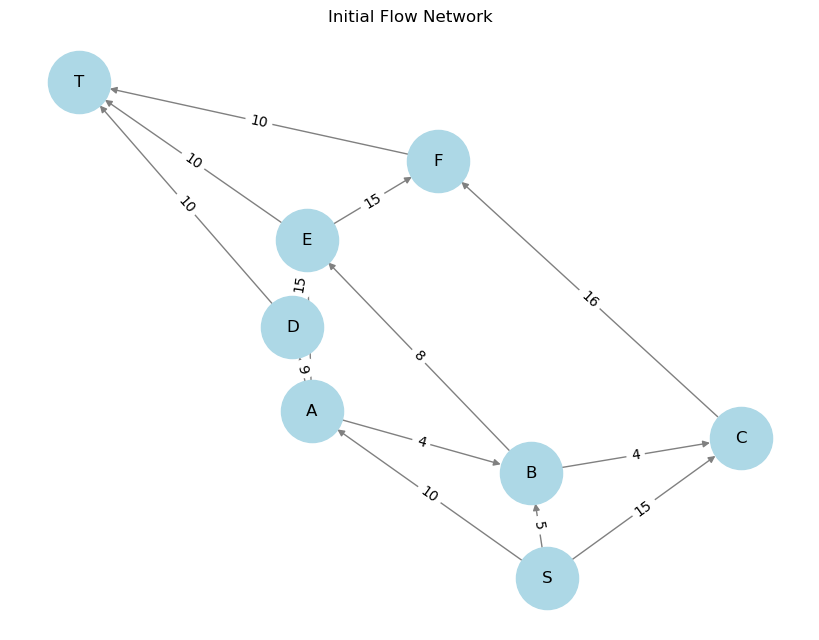

Maximum Flow: 25


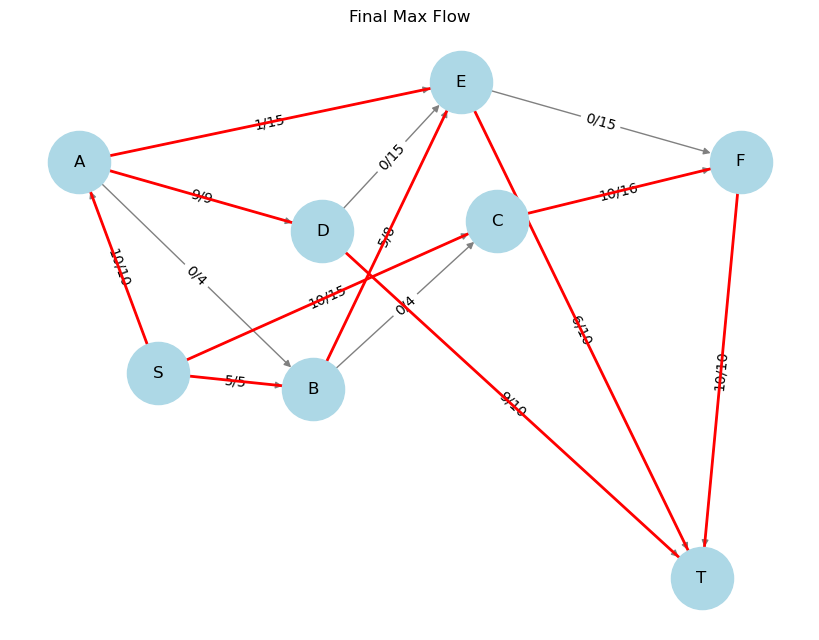

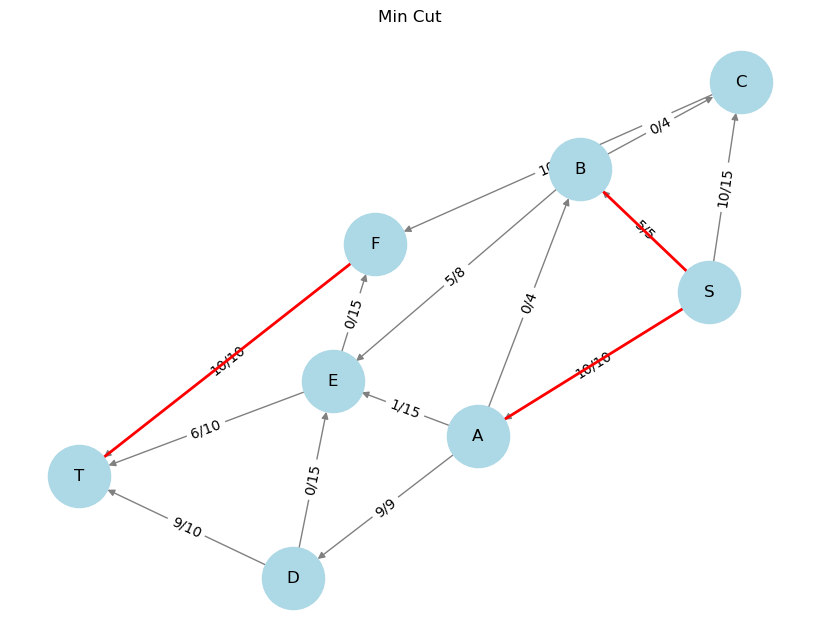

In [9]:
def draw_graph(G, flow_dict=None, title="Graph", highlight_edges=None):
    """
    Draws the graph with flow values if provided.
    """
    pos = nx.spring_layout(G)  # Positioning nodes
    plt.figure(figsize=(8, 6))

    # Draw nodes and edges
    nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=2000, font_size=12)
    
    # Draw edge labels (capacity or flow values)
    edge_labels = {(u, v): f"{G[u][v]['capacity']}" for u, v in G.edges()}
    if flow_dict:
        edge_labels = {(u, v): f"{flow_dict[u][v]}/{G[u][v]['capacity']}" for u, v in G.edges()}
    
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)
    
    # Highlight certain edges (for min-cut or max flow paths)
    if highlight_edges:
        nx.draw_networkx_edges(G, pos, edgelist=highlight_edges, edge_color="red", width=2)

    plt.title(title)
    plt.show()


def visualize_residual_graph(G, residual_G, step):
    """
    Visualizes the residual graph at a given step.
    """
    pos = nx.spring_layout(G)
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=2000, font_size=12)
    
    # Draw residual capacities
    residual_labels = {(u, v): f"{residual_G[u][v]['capacity']}" for u, v in residual_G.edges()}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=residual_labels, font_size=10)
    
    plt.title(f"Residual Network - Step {step}")
    plt.show()


def ford_fulkerson_demo():
    """
    Demonstrates the Ford-Fulkerson algorithm with visualizations.
    """
    # Step 1: Create a directed graph with capacities
    G = nx.DiGraph()
    edges = [
        ("S", "A", 10), ("S", "B", 5), ("S", "C", 15),
        ("A", "B", 4), ("A", "D", 9), ("A", "E", 15),
        ("B", "C", 4), ("B", "E", 8),
        ("C", "F", 16),
        ("D", "E", 15), ("D", "T", 10),
        ("E", "F", 15), ("E", "T", 10),
        ("F", "T", 10)
    ]
    
    for u, v, capacity in edges:
        G.add_edge(u, v, capacity=capacity)

    draw_graph(G, title="Initial Flow Network")

    # Step 2: Compute Max Flow using Ford-Fulkerson
    source, sink = "S", "T"
    max_flow, flow_dict = nx.maximum_flow(G, source, sink)

    print(f"Maximum Flow: {max_flow}")

    # # Step 3: Visualize Residual Network at Steps
    # residual_G = G.copy()
    # for u in G.nodes():
    #     for v in G.nodes():
    #         if residual_G.has_edge(u, v):
    #             residual_G[u][v]['capacity'] -= flow_dict[u][v]
    
    # visualize_residual_graph(G, residual_G, step="Final")

    # Step 4: Highlight the Optimal Flow Path in Red
    flow_edges = [(u, v) for u, v in G.edges() if flow_dict[u][v] > 0]
    draw_graph(G, flow_dict, title="Final Max Flow", highlight_edges=flow_edges)

    # Step 5: Compute and Highlight the Min Cut
    _, partition = nx.minimum_cut(G, source, sink)
    reachable, non_reachable = partition  # Extract the two node groups
    cut_edges = [(u, v) for u in reachable for v in G[u] if v in non_reachable]
    draw_graph(G, flow_dict, title="Min Cut", highlight_edges=cut_edges)


# Run the Demo
ford_fulkerson_demo()